In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np

PROC_DATA_PATH = '~/library/data/processed/'

econ_features = ['3_year_survival_rate', 'job_density', '3_year_survival_number', 'number_of_jobs','youth_unemployment_rate']
qualif_features = ['NVQ4_rate', 'youth_unemployment_rate', 'no_qualif_rate', 'NVQ3_rate', 'NVQ2_rate', 'NVQ1_rate']

In [25]:
# Load in the data
df = pd.read_csv(PROC_DATA_PATH + 'youth_data_labelled.csv', sep=',', index_col=0)

In [26]:
df.head()

,area,year,3_year_survival_number,3_year_survival_rate,number_of_jobs,job_density,unemployment_rate,NVQ4_rate,youth_unemployment_rate,no_qualif_rate,NVQ3_rate,NVQ2_rate,NVQ1_rate,group_qualif,group_econ
0,Barking and Dagenham,2011,455.0,54.5,54000,0.45,13.0,33.2,22.734367,8.6,13.7,16.3,14.3,2,0
1,Barnet,2011,1635.0,57.7,147000,0.62,8.0,57.3,9.944418,3.7,10.9,9.3,7.5,0,1
2,Bexley,2011,555.0,58.7,78000,0.53,8.0,29.6,10.870386,4.8,19.0,19.2,17.2,1,0
3,Brent,2011,1085.0,56.7,115000,0.53,10.8,33.8,14.681718,8.2,14.8,11.4,9.2,2,0
4,Bromley,2011,990.0,62.7,119000,0.61,6.9,47.1,10.269752,5.4,17.5,12.8,10.5,0,1


Here we split the data into qualifications and geographical features (or economic), and standardize it. Standardizing means to rescale the data to have a mean of zero and a standard deviation of one. This is a requirement for kmeans, as we work with euclidian distances.

In [4]:
qualif_df = df[qualif_features].copy()
econ_df = df[econ_features].copy()

In [5]:
X = econ_df.values
#standardize the data
X_std = StandardScaler().fit_transform(X)

In [6]:
Y = qualif_df.values
#standardize the data
Y_std = StandardScaler().fit_transform(Y)

To reduce dimensionality of the data for visualisation (and to improve runtimes of ML algorithms) we use a statistical method called PCA. PCA uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components (PCs). 

Without getting too technical about the mathematical concepts at hand, the orthogonal (linear) transformation involved transforms the data to a new coordinate system such that the greatest variance by some scalar projection of the data comes to lie on the first coordinate (called the first PC), the second greatest variance on the second coordinate, and so on.

The resulting vectors (each being a linear combination of the variables and containing n observations) are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables, hence standardization of variables here came in handy. 

The transformation maps a data vector from an original space of p variables to a new space of p variables. However, not all the principal components need to be kept. As we demonstrate below, in this case only 2 PCs were considered, because they encompass > 85% of the variance of the dataset, hence describing the original variables well.

First PC encompasses 57.373119% variance, second PC 28.629967%, and third 9.363291%


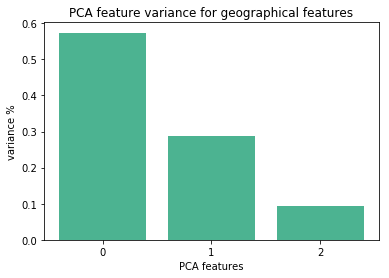

In [7]:
# Create a PCA instance: pca
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances to identify no of needed PCs
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='#4CB391')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.title('PCA feature variance for geographical features')
plt.xticks(features)
print("First PC encompasses {:f}% variance, second PC {:f}%, and third {:f}%".format(*pca.explained_variance_ratio_*100))

PCs have 56.894592% variance, 25.932796%, 8.003612%, 6.150398%, 2.485986%


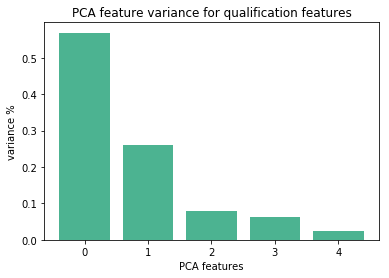

In [8]:
# Create a PCA instance: pca
pca_qualif = PCA(n_components=5)
principalComponents_ = pca_qualif.fit_transform(Y_std)

# Plot the explained variances to identify no of needed PCs
features = range(pca_qualif.n_components_)
plt.bar(features, pca_qualif.explained_variance_ratio_, color='#4CB391')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.title('PCA feature variance for qualification features')
plt.xticks(features)
print("PCs have {:f}% variance, {:f}%, {:f}%, {:f}%, {:f}%".format(*pca_qualif.explained_variance_ratio_*100))

For qualifications the ideal number of PCA features is 3, as we capture ~ 90% of the variance

In [9]:
PCA_components = pd.DataFrame(principalComponents)

In [10]:
PCA_components_qualif = pd.DataFrame(principalComponents_)

Text(0.5, 1.0, 'PCA feature scatterplot for geographic features')

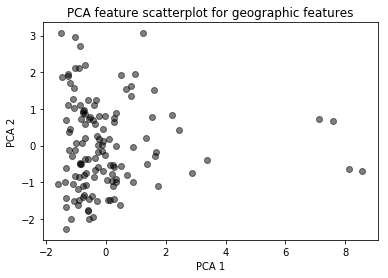

In [11]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.5, c='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA feature scatterplot for geographic features')

Text(0.5, 0.92, 'PCA feature scatterplot for qualification features')

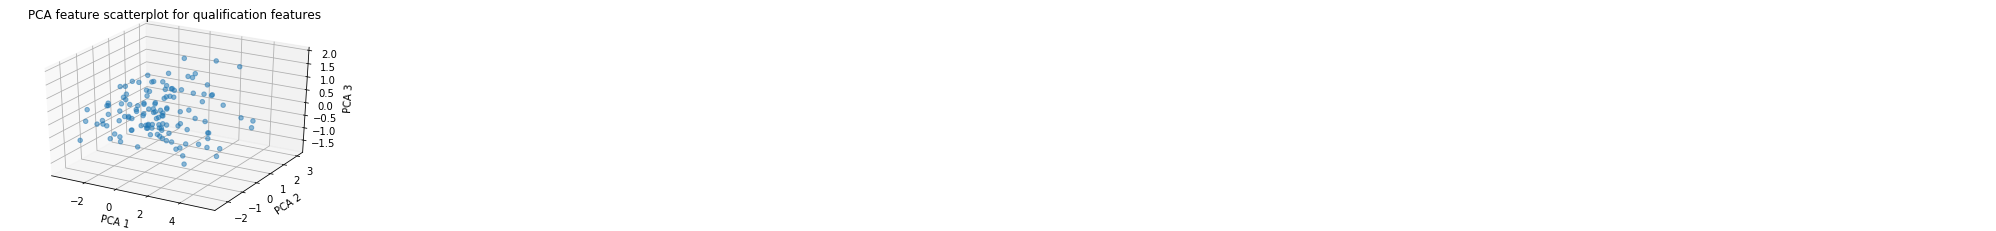

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PCA_components_qualif[0], PCA_components_qualif[1], PCA_components_qualif[2], alpha=.5)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.title('PCA feature scatterplot for qualification features')

Below we instantiate a kmeans model to cluster the geographic data. A cluster refers to a collection of data points aggregated together because of certain similarities (euclidian distance between points). K-means clustering is an unsupervised machine learning algorithms, meaning that the data has not been labelled yet. 

We need to find an optimal number k, which refers to the optimal number of centroids you need in the dataset. A centroid is the imaginary or real location representing the center of the cluster. To find this centroid, every data point is allocated to each of the clusters through reducing the in-cluster sum of squares. To determine the optimal number of centroids needed, we can use a visual method called the Elbow Criterion.

Elbow Criterion Method:

The idea behind elbow method is to run k-means clustering on a given dataset for a range of values k (n_clusters, e.g k=1 to 10), and for each value k, calculate the sum of squared errors (SSE), or inertia. After that, plot a line graph of the inertia for each value of k. We can determine the number of optimal clusters by choosing a number k after which we have diminishing returns by increasing k. Inertia tends to decrease toward 0 as we increase k (and is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster).

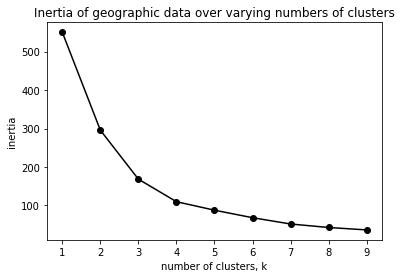

In [13]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters
    model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=0)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:2])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.title('Inertia of geographic data over varying numbers of clusters')
plt.xticks(ks)
plt.show()

Here the ideal number of clusters is k=3, for geographic features.

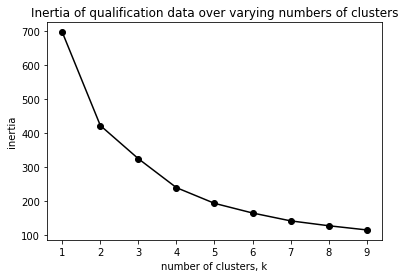

In [14]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=0)
    
    # Fit model to samples
    model.fit(PCA_components_qualif.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.title('Inertia of qualification data over varying numbers of clusters')
plt.xticks(ks)
plt.show()

And for qualifications it is k=4

Here The red dots represent the centroids determined by kmeans

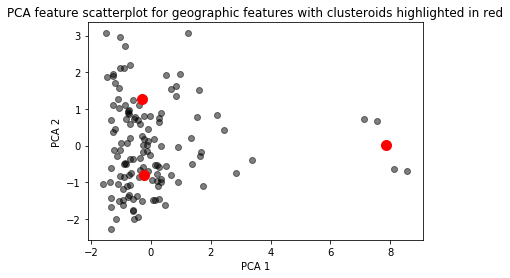

In [15]:
model = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = model.fit_predict(PCA_components.iloc[:,:3])
plt.scatter(PCA_components[0], PCA_components[1], alpha=.5, c='black')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=100, c='red')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA feature scatterplot for geographic features with clusteroids highlighted in red')
plt.show()

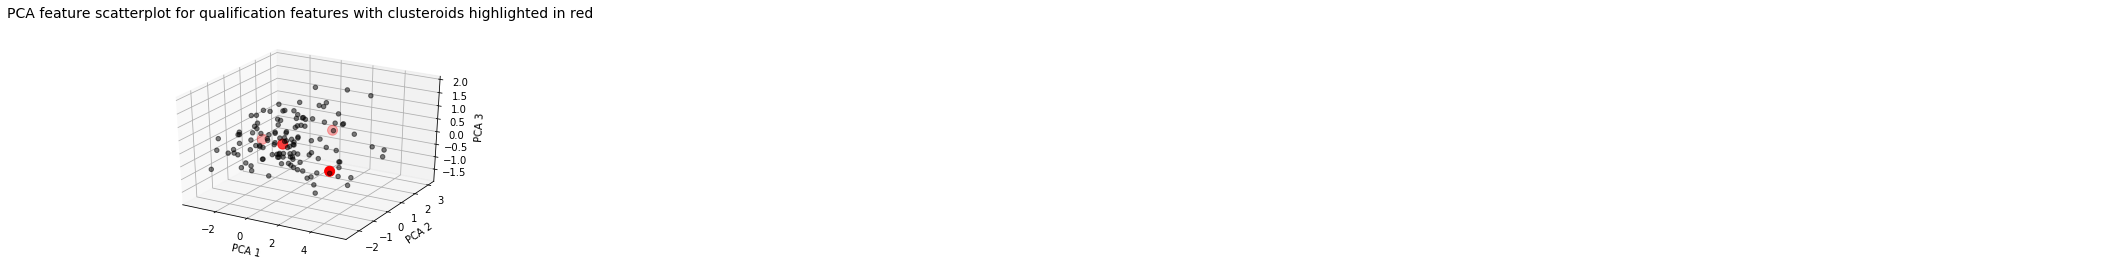

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

model_qualif = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = model_qualif.fit_predict(PCA_components_qualif.iloc[:,:3])
ax.scatter(PCA_components_qualif[0], PCA_components_qualif[1], PCA_components_qualif[2], alpha=.5, c='black')
ax.scatter(model_qualif.cluster_centers_[:, 0], model_qualif.cluster_centers_[:, 1], model_qualif.cluster_centers_[:, 2], s=100, c='red')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
fig.suptitle('PCA feature scatterplot for qualification features with clusteroids highlighted in red', fontsize=14)
plt.show()

In [17]:
model.labels_

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2], dtype=int32)

In [18]:
econ_df['group'] = model.labels_
qualif_df['group'] = model_qualif.labels_

In [19]:
econ_df.columns

Index(['3_year_survival_rate', 'job_density', '3_year_survival_number',
       'number_of_jobs', 'youth_unemployment_rate', 'group'],
      dtype='object')

In [20]:
qualif_df.columns

Index(['NVQ4_rate', 'youth_unemployment_rate', 'no_qualif_rate', 'NVQ3_rate',
       'NVQ2_rate', 'NVQ1_rate', 'group'],
      dtype='object')

Text(0.5, 0.98, 'PCA feature scatterplot for qualification features with clusteroids highlighted in red')

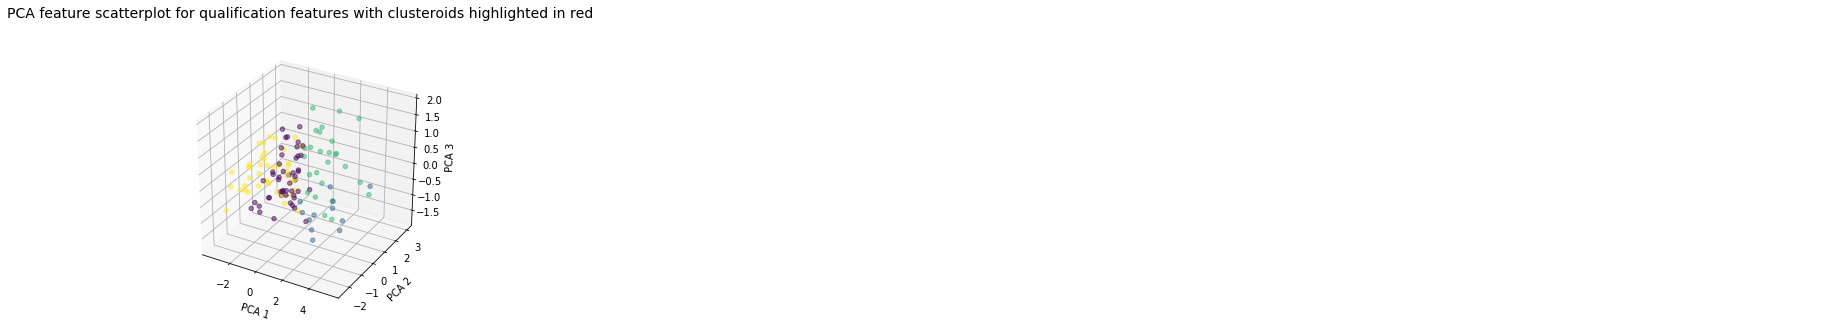

In [21]:
PCA_components_qualif['group'] = model_qualif.labels_
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PCA_components_qualif[0], PCA_components_qualif[1], PCA_components_qualif[2], alpha=.5, c=PCA_components_qualif['group'])
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
fig.suptitle('PCA feature scatterplot for qualification features with clusteroids highlighted in red', fontsize=14)

In [22]:
df['group_econ'] = model.labels_
df['group_qualif'] = model_qualif.labels_

In [23]:
df.to_csv(PROC_DATA_PATH + 'youth_data_labelled.csv')